In [8]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function_goku_pre_frontera.txt', unpack=True, usecols=(0,1,2))

In [301]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [302]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=10, sigma=1)
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=1, sigma=1)
    beta_L = pm.Normal("beta_L", mu=1, sigma=.3)
    beta_H = pm.Normal("beta_H", mu=3, sigma=1)
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = pm.Normal("beta_H2", mu=3, sigma=1)
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = pm.Normal("alpha_L", mu=10, sigma=3)
    alpha_1 = pm.Normal("alpha_1", mu=10, sigma=3)
    alpha_2 = pm.Normal("alpha_2", mu=10, sigma=3)
    # rho_H = pm.Normal("rho_H", mu=1, sigma=.2)

    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=np.log10(rel_error))

In [303]:
error_mean

0.07751065322334456

In [304]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(6000, tune=2000, chains=4) # chains=6 would still use 4 cores

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2, sigma]


Output()

Sampling 6 chains for 2_000 tune and 6_000 draw iterations (12_000 + 36_000 draws total) took 941 seconds.


In [305]:
dict(idata)

{'posterior': <xarray.Dataset> Size: 3MB
 Dimensions:  (chain: 6, draw: 6000)
 Coordinates:
   * chain    (chain) int64 48B 0 1 2 3 4 5
   * draw     (draw) int64 48kB 0 1 2 3 4 5 6 ... 5994 5995 5996 5997 5998 5999
 Data variables:
     alpha_1  (chain, draw) float64 288kB 19.52 19.75 19.23 ... 19.36 19.16 19.19
     alpha_2  (chain, draw) float64 288kB 7.839 8.187 6.759 ... 7.205 3.871 11.77
     alpha_L  (chain, draw) float64 288kB 10.15 10.69 7.795 ... 7.378 5.009 8.948
     beta_H   (chain, draw) float64 288kB 4.332 4.257 4.25 ... 4.267 4.142 4.288
     beta_H2  (chain, draw) float64 288kB 3.031 2.975 2.675 ... 3.427 3.401 3.132
     beta_L   (chain, draw) float64 288kB 1.125 1.122 1.145 ... 1.077 1.1 1.091
     eta      (chain, draw) float64 288kB 11.63 11.41 10.62 ... 9.489 9.443 12.18
     rho      (chain, draw) float64 288kB 8.683e+04 6.819e+04 ... 5.955e+04
     sigma    (chain, draw) float64 288kB 0.2145 0.2129 0.2146 ... 0.2179 0.21
 Attributes:
     created_at:            

In [306]:
idata.posterior.data_vars

Data variables:
    alpha_1  (chain, draw) float64 288kB 19.52 19.75 19.23 ... 19.36 19.16 19.19
    alpha_2  (chain, draw) float64 288kB 7.839 8.187 6.759 ... 7.205 3.871 11.77
    alpha_L  (chain, draw) float64 288kB 10.15 10.69 7.795 ... 7.378 5.009 8.948
    beta_H   (chain, draw) float64 288kB 4.332 4.257 4.25 ... 4.267 4.142 4.288
    beta_H2  (chain, draw) float64 288kB 3.031 2.975 2.675 ... 3.427 3.401 3.132
    beta_L   (chain, draw) float64 288kB 1.125 1.122 1.145 ... 1.077 1.1 1.091
    eta      (chain, draw) float64 288kB 11.63 11.41 10.62 ... 9.489 9.443 12.18
    rho      (chain, draw) float64 288kB 8.683e+04 6.819e+04 ... 5.955e+04
    sigma    (chain, draw) float64 288kB 0.2145 0.2129 0.2146 ... 0.2179 0.21

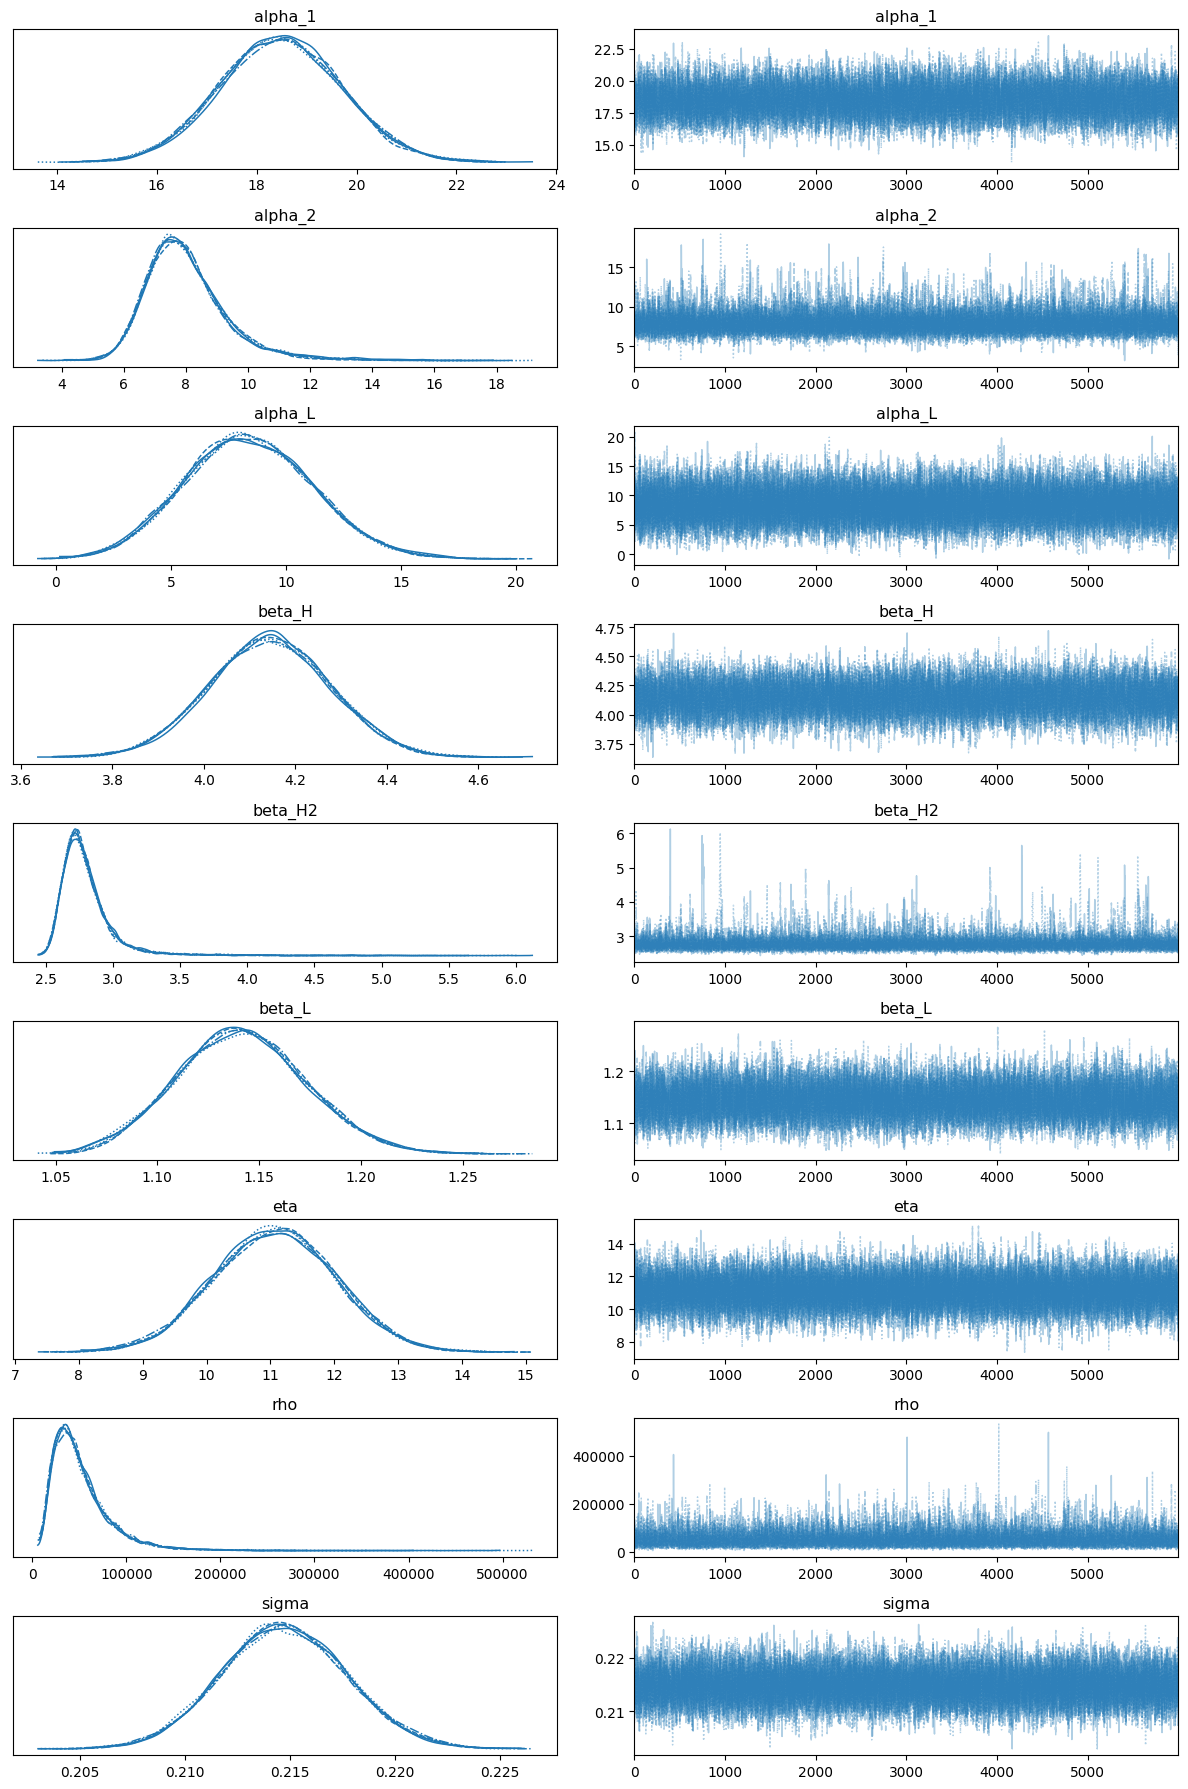

In [307]:
az.plot_trace(idata)
plt.tight_layout()

In [308]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
print(credible_interval_eta)
print(credible_interval_rho)
print(credible_interval_beta_L)
print(credible_interval_beta_H)


[10.11900462 11.07276967 12.01096077]
[24979.26437757 43692.7093836  76270.24159775]
[1.10961524 1.14072027 1.17294341]
[4.01315938 4.14358047 4.27619543]


In [309]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_1,18.479,1.209,16.157,20.705,0.010,0.007,13725.821,17244.465,1.000
alpha_2,8.016,1.350,5.845,10.626,0.012,0.009,18454.366,10285.696,1.000
alpha_L,8.398,2.771,3.255,13.626,0.016,0.012,31137.995,24690.079,1.000
beta_H,4.144,0.132,3.893,4.390,0.001,0.001,12411.794,14788.620,1.000
beta_H2,2.799,0.221,2.524,3.126,0.003,0.002,11673.372,6648.160,1.001
beta_L,1.141,0.032,1.085,1.204,0.000,0.000,11894.400,8797.765,1.000
eta,11.071,0.952,9.310,12.870,0.006,0.004,29801.142,24432.397,1.000
rho,51239.078,31632.520,9712.640,105911.942,276.866,195.778,13166.860,16083.852,1.001
sigma,0.215,0.003,0.209,0.220,0.000,0.000,27235.129,23361.326,1.000


In [310]:
posterior_eta.values.flatten()

array([11.62825092, 11.40995881, 10.6197314 , ...,  9.48859323,
        9.4428722 , 12.18497787])

In [311]:
# Alternative method to find mode using histogram
def get_histogram_mode(data, bins=500):
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mode = bin_centers[np.argmax(hist)]
    return mode

# Extracting modes using histogram method for comparison
hist_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_histogram_mode(samples)
    hist_modes[var] = mode

print("Histogram modes of each posterior:")
for var, mode in hist_modes.items():
    print(f"{var}: {mode}")

Histogram modes of each posterior:
alpha_1: 18.637498068190297
alpha_2: 7.447317831317287
alpha_L: 7.442840229493554
beta_H: 4.141629790028926
beta_H2: 2.705887452105391
beta_L: 1.1362046532878236
eta: 11.300014976514543
rho: 35446.91927212635
sigma: 0.21470786898135175


In [312]:
from scipy.stats import gaussian_kde

# Assuming `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Function to compute the mode using KDE
def get_mode_kde(data):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 1000)
    mode = x_grid[np.argmax(kde(x_grid))]
    return mode

# Extracting modes for each parameter using KDE
kde_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_mode_kde(samples)
    kde_modes[var] = mode

print("KDE modes of each posterior:")
for var, mode in kde_modes.items():
    print(f"{var}: {mode}")


KDE modes of each posterior:
alpha_1: 18.553167013696203
alpha_2: 7.5153891398955235
alpha_L: 7.8176404049598816
beta_H: 4.145389781446169
beta_H2: 2.713544143928366
beta_L: 1.1406839520015446
eta: 11.20294568777112
rho: 34422.595850790254
sigma: 0.21450697746101002


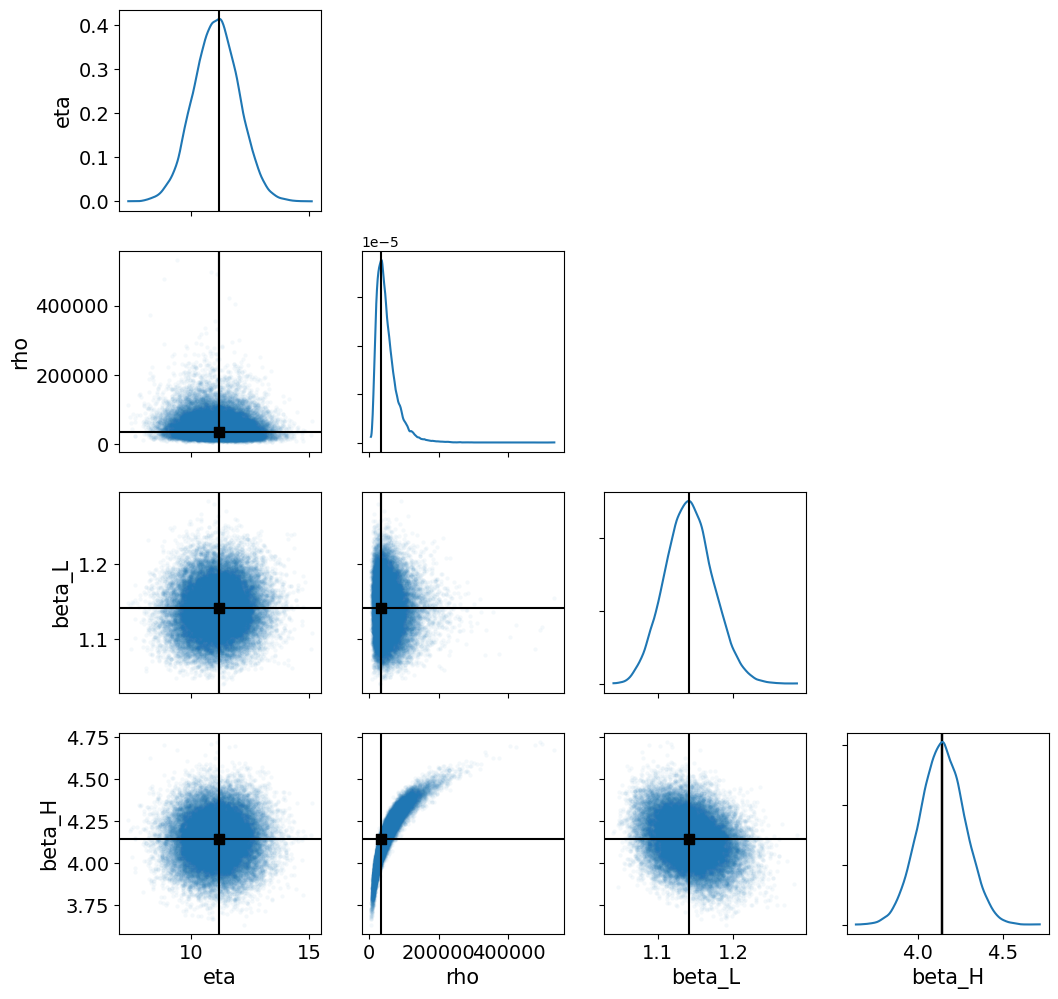

In [313]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="mode",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [10]:
# define the error function 2 param modes
def error_function(n_LF, n_HF):
    eta = 11.20294568777112
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = 34422.595850790254
    beta_L = 1.1406839520015446
    beta_H = 4.145389781446169
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = 2.713544143928366
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = 7.8176404049598816
    alpha_1 = 18.553167013696203
    alpha_2 = 7.5153891398955235

    sigma_lg_Phi = 0.21450697746101002   # standard deviation of the log of the error function
    # return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))
    lg_Phi = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))
    
    mode_Phi = 10**lg_Phi * np.exp(-sigma_lg_Phi**2 * (np.log(10))**2)
    mean_Phi = 10**lg_Phi * np.exp(1/2 * (sigma_lg_Phi * np.log(10))**2)
    median_Phi = 10**lg_Phi
    return median_Phi

In [11]:
# loss  mean
lg_phi = np.log10(error_function(n_LF, n_HF))
loss = np.mean((lg_phi - np.log(rel_error))**2)

In [12]:
loss

3.9987962922699007